In [38]:
import os
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [39]:
train_path = os.path.join('datasets', 'housing_prices', 'train.csv')
train_df = pd.read_csv(train_path)

test_path = os.path.join('datasets', 'housing_prices', 'test.csv')
test_df = pd.read_csv(test_path)

print(f'Train shape {train_df.shape}')
print(f'Test shape {test_df.shape}')
train_df.head()

Train shape (1460, 81)
Test shape (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


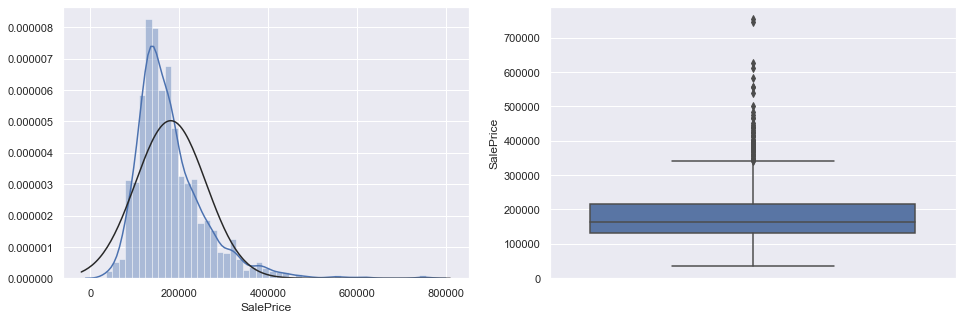

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(train_df['SalePrice'], ax=axes[0], fit=norm)
sns.boxplot(y=train_df['SalePrice'], ax=axes[1])

### Removing outliers and normalizing labels

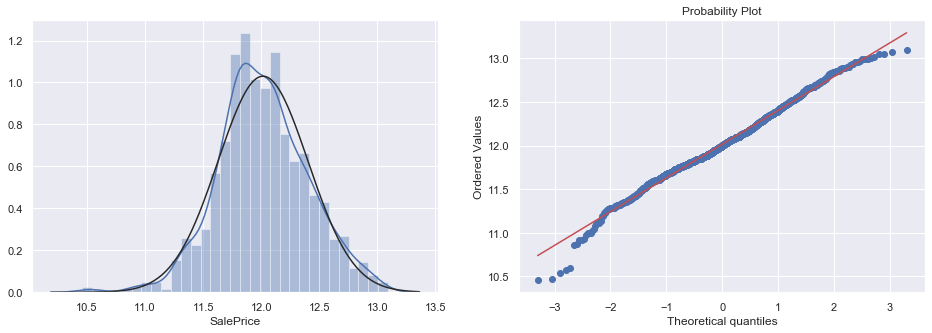

In [41]:
train_df = train_df.loc[train_df['SalePrice'] <= 500_000]
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
_, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(train_df['SalePrice'], fit=norm, ax=axes[0])
probplot(train_df['SalePrice'], plot=axes[1]);

### Filling Null values

In [42]:
all_train = train_df.append(test_df)
nulls = (all_train.isna().sum() / all_train.shape[0]) * 100
nulls[nulls > 0].sort_values(ascending=False)

PoolQC          99.690722
MiscFeature     96.391753
Alley           93.195876
Fence           80.412371
SalePrice       50.137457
FireplaceQu     48.797251
LotFrontage     16.701031
GarageYrBlt      5.463918
GarageFinish     5.463918
GarageQual       5.463918
GarageCond       5.463918
GarageType       5.395189
BsmtCond         2.817869
BsmtExposure     2.817869
BsmtQual         2.783505
BsmtFinType2     2.749141
BsmtFinType1     2.714777
MasVnrType       0.824742
MasVnrArea       0.790378
MSZoning         0.137457
BsmtFullBath     0.068729
BsmtHalfBath     0.068729
Functional       0.068729
Utilities        0.068729
BsmtFinSF2       0.034364
BsmtUnfSF        0.034364
BsmtFinSF1       0.034364
TotalBsmtSF      0.034364
SaleType         0.034364
KitchenQual      0.034364
Exterior2nd      0.034364
Exterior1st      0.034364
GarageCars       0.034364
GarageArea       0.034364
Electrical       0.034364
dtype: float64

In [43]:
all_train['PoolQC'].fillna('None', inplace=True)
all_train['MiscFeature'].fillna('None', inplace=True)
all_train['Alley'].fillna('None', inplace=True)
all_train['Fence'].fillna('None', inplace=True)
all_train['FireplaceQu'].fillna('None', inplace=True)

lot_mean = train_df.groupby('Neighborhood')['LotFrontage'].mean()
all_train = pd.merge(all_train, lot_mean, on='Neighborhood', suffixes=('', '_mean'))
all_train['LotFrontage'].fillna(all_train['LotFrontage_mean'], inplace=True)
all_train.drop(columns='LotFrontage_mean', inplace=True)

all_train['GarageYrBlt'].fillna(0, inplace=True)
all_train['GarageFinish'].fillna('None', inplace=True)
all_train['GarageQual'].fillna('None', inplace=True)
all_train['GarageCond'].fillna('None', inplace=True)
all_train['GarageType'].fillna('None', inplace=True)

all_train['BsmtCond'].fillna('None', inplace=True)
all_train['BsmtExposure'].fillna('None', inplace=True)
all_train['BsmtQual'].fillna('None', inplace=True)
all_train['BsmtFinType2'].fillna('None', inplace=True)
all_train['BsmtFinType1'].fillna('None', inplace=True)

all_train['MasVnrType'].fillna('None', inplace=True)
all_train['MasVnrArea'].fillna(0, inplace=True)

all_train['MSZoning'].fillna(train_df['MSZoning'].mode()[0], inplace=True)
all_train['BsmtFullBath'].fillna(0, inplace=True)
all_train['BsmtHalfBath'].fillna(0, inplace=True)

all_train['Functional'].fillna('Typ', inplace=True)
all_train['Utilities'].fillna('AllPub', inplace=True)
all_train['BsmtFinSF2'].fillna(0, inplace=True)
all_train['BsmtUnfSF'].fillna(0, inplace=True)
all_train['BsmtFinSF1'].fillna(0, inplace=True)
all_train['TotalBsmtSF'].fillna(0, inplace=True)
all_train['SaleType'].fillna('Oth', inplace=True)

all_train['KitchenQual'].fillna('TA', inplace=True)
all_train['Exterior2nd'].fillna('Other', inplace=True)
all_train['Exterior1st'].fillna('Other', inplace=True)
all_train['GarageCars'].fillna(0, inplace=True)
all_train['GarageArea'].fillna(0, inplace=True)
all_train['Electrical'].fillna('Mix', inplace=True)

all_train.isna().any().sum()

1

### EDA

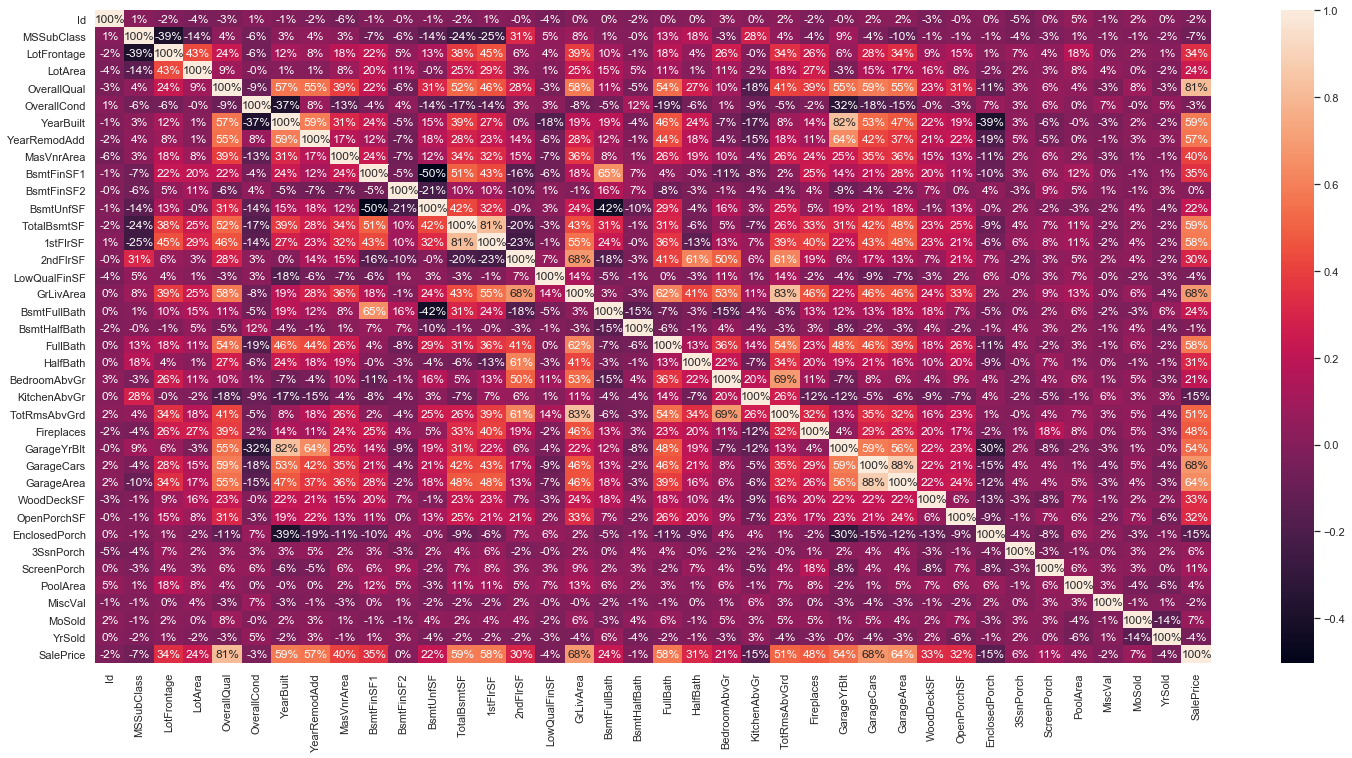

In [44]:
plt.figure(figsize=(25, 12))
corr_mat = train_df.corr()
sns.heatmap(corr_mat, annot=True, fmt='.0%')

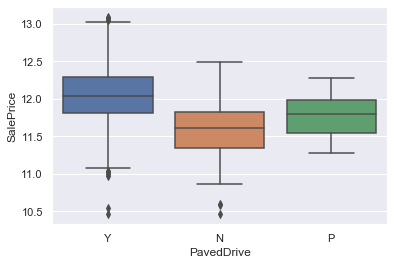

In [45]:
'Neiggborhood'
'HouseStyle'
'CentralAir'
'TotRmsAbvGrd'

'YearBuilt'
'GarageYrBlt'
'BsmtFinSF1'
'TotalBsmtSF'
'1stFlrSF'
'2ndFlrSF'
'GrLivArea'
'GarageArea'

'TotRmsAbvGrd' + 'FullBath'

sns.boxplot(y='SalePrice', x='PavedDrive', data=train_df)

Quality is really important

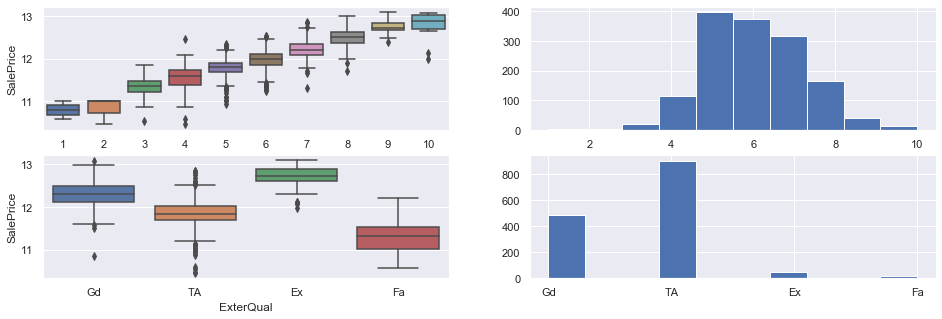

In [46]:
_, axes = plt.subplots(2, 2, figsize=(16, 5))
cols = ['OverallQual', 'ExterQual']
for i, col in enumerate(cols):
    ax1, ax2 = axes[i]
    sns.boxplot(y='SalePrice', x=col, data=train_df, ax=ax1)
    train_df[col].hist(ax=ax2)

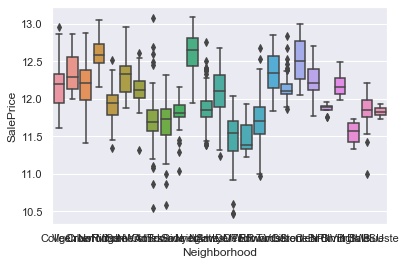

In [47]:
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df)

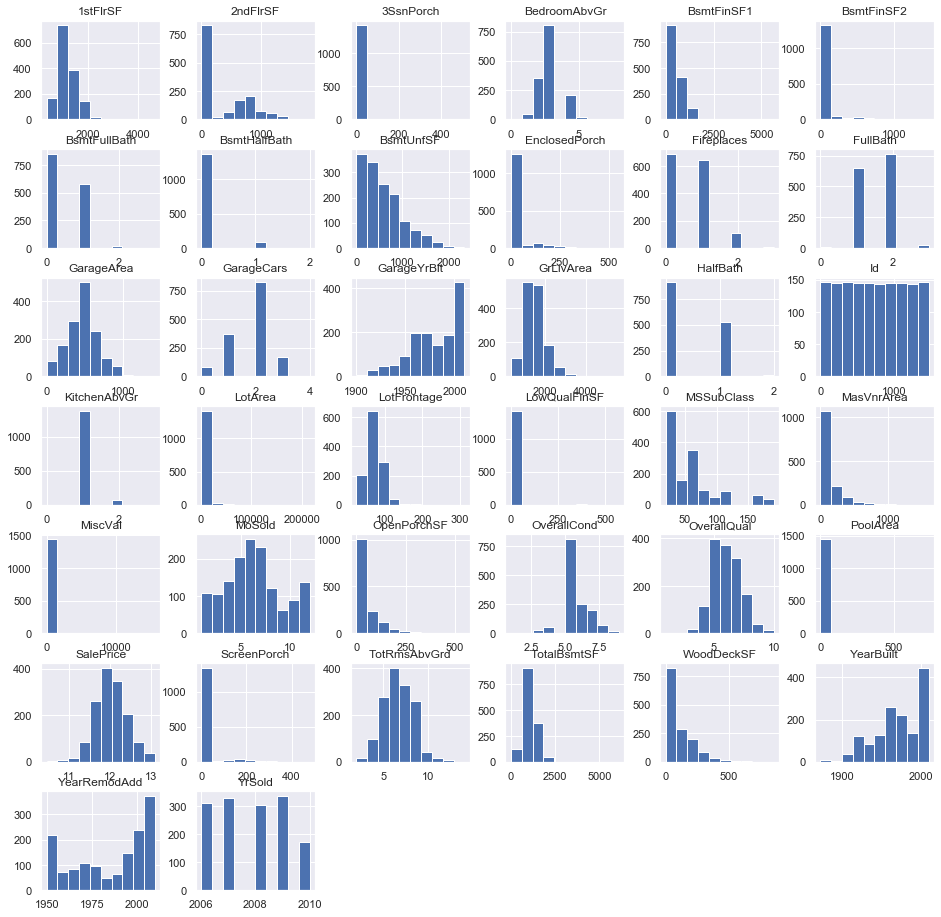

In [52]:
train_df.select_dtypes(exclude='object').hist(figsize=(16,16));

### Machine Learning

First model - just to check

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

### Changes in features

In [12]:
all_train.drop(columns=['Utilities'], inplace=True)

all_train['MSSubClass'] = all_train['MSSubClass'].astype('object')
all_train['OverallQual'] = all_train['OverallQual'].astype('object')
all_train['OverallCond'] = all_train['OverallCond'].astype('object')

all_train['TotalRooms'] = all_train['TotRmsAbvGrd'] + all_train['FullBath']
all_train['TotalSF'] = all_train['TotalBsmtSF'] + all_train['1stFlrSF'] + all_train['2ndFlrSF']

In [13]:
train = all_train[all_train['Id'].isin(train_df['Id'])]
test = all_train[all_train['Id'].isin(test_df['Id'])]

In [14]:
train = pd.get_dummies(train)

In [15]:
train_df, valid_df = train_test_split(train, random_state=42, test_size=0.2)
X_train = train_df.drop(columns='SalePrice')
Y_train = train_df['SalePrice']

X_valid = valid_df.drop(columns='SalePrice')
Y_valid = valid_df['SalePrice']

In [16]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_valid)

In [17]:
np.sqrt(mean_squared_error(Y_valid, Y_pred))

0.12681884219226047

### Lasso Regression